In [2]:
# ================================================================================ #
# =========================== Goolge Colab File Upload =========================== #
# ================================================================================ #

from google.colab import drive
drive.mount('/content/drive')

# 출력값 초기화
from google.colab import output
output.clear()

# 경로 수정
import os
os.chdir("drive/MyDrive/Colab Notebooks/가스공급량 수요예측 모델개발")

In [3]:
# import libary
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
import os, glob, sys
import matplotlib.pyplot as plt

train_csv = pd.read_csv("./datasets/한국가스공사_시간별 공급량.csv", encoding = 'cp949', engine='python')

# test_csv 파일 전처리
test_csv = pd.read_csv("./datasets/test.csv", encoding = 'utf-8')

test_date = []
test_hour = []
test_class = []

for component in test_csv.values:
    string = component.item()
    test_date.append(string.split(" ")[0])
    test_hour.append(string.split(" ")[1])
    test_class.append(string.split(" ")[-1])

test_csv = pd.DataFrame({'연월일':test_date, "시간":test_hour, "구분":test_class})
sample_submission = pd.read_csv("./datasets/sample_submission.csv", encoding = "utf-8")

In [4]:
# rename column
train_csv.rename(columns = {'연월일' : 'time', "시간":"hour", "구분":"class", "공급량":"power"}, inplace = True)

In [5]:
# rename column
test_csv.rename(columns = {'연월일' : 'time', "시간":"hour", "구분":"class"}, inplace = True)

In [6]:
# 자료형 변환
from datetime import datetime

# time : str to datetime
try:
    train_csv["time"] = train_csv["time"].apply(lambda x : datetime.strptime(x, "%Y-%m-%d"))
    test_csv["time"] = test_csv["time"].apply(lambda x : datetime.strptime(x, "%Y-%m-%d"))
except:
    print("data type of time not str or already converted")

# hour : str to int

try:
    test_csv["hour"] = test_csv["hour"].apply(lambda x : int(x))
except:
    print("data type of hour not str or already converted")

In [7]:
# time - hour => timestamp with yyyy-mm-dd-hh
import datetime

def df_time_convert(df):
    df_copy = df.copy(...)
    timestamp_list = []
    for idx in range(len(df)):
        timestamp_list.append(df_copy.time.iloc[idx] + datetime.timedelta(hours = df_copy.hour.iloc[idx].item()))
    df_copy["time"] = timestamp_list
    return df_copy

# class에 따른 데이터프레임 분류
def df_class_split(df, cls = "A"):
    df_copy = df.copy(...)
    df_copy = df_copy[df_copy["class"] == cls]
    return df_copy

# class to idx
def class_to_idx(x):
    dic = {'A':0,"B":1,"C":2,"D":3,'E':4,'G':5,"H":6}
    if type(x) == str:
        try:
            return_value = int(dic[x])
        except:
            return_value = 0
            print("didn't find class {}".format(x))

    else:
        return_value = 0
    
    return return_value

# convert original scale to log scale
def convert2log(x):
    eps = 1e-6
    if abs(x) < eps:
        return NaN
    else:
        return np.log1p(x)
    
def convert2origin(x):
    return np.exp(x) - 1

In [8]:
# External Data(weather)
import glob2
import datetime

path_list_external_weather = glob2.glob("./dataset_external_weather/*")
print(path_list_external_weather)

df_weather = None
for idx, path in enumerate(path_list_external_weather):

    if idx == 0:
        df_weather = pd.read_csv(path, encoding = "cp949")
    else:
        df_temp = pd.read_csv(path, encoding = "cp949")
        df_weather = pd.concat([df_weather, df_temp], axis = 0)


# column name change
df_weather.rename(columns = {"일시": "date_time","기온(°C)" : "temperature", "습도(%)":"humidity", "증기압(hPa)" : "vapor", "현지기압(hPa)":"pressure", "풍속(m/s)":"wind_speed"}, inplace = True)

df_weather["date_time"] = df_weather["date_time"].apply(lambda x : datetime.datetime.strptime(x,"%Y-%m-%d %H:%M" ))

# 결측치 보완
df_weather["temperature"] = df_weather["temperature"].interpolate(method = "values")
df_weather["humidity"] = df_weather["humidity"].interpolate(method = "values")
df_weather["vapor"] = df_weather["vapor"].interpolate(method = "values")
df_weather["wind_speed"] = df_weather["wind_speed"].interpolate(method = "values")
df_weather["pressure"] = df_weather["pressure"].interpolate(method = "values")

# merge
df = train_csv.copy()
df = df_time_convert(df)
df["class"] = df["class"].apply(lambda x : int(class_to_idx(x)))

df_merge = pd.merge(left = df, right = df_weather[["date_time", "temperature", "humidity", "vapor", "pressure", "wind_speed"]], how = 'outer', left_on = "time", right_on = "date_time")
df_merge = df_merge.drop(columns = ['date_time'], axis = 1)

['./dataset_external_weather/OBS_ASOS_TIM_20211017003024.csv', './dataset_external_weather/OBS_ASOS_TIM_20211017003117.csv', './dataset_external_weather/OBS_ASOS_TIM_20211017004006.csv', './dataset_external_weather/OBS_ASOS_TIM_20211017004047.csv', './dataset_external_weather/OBS_ASOS_TIM_20211017004154.csv', './dataset_external_weather/OBS_ASOS_TIM_20211017004224.csv']


In [9]:
df_merge = df_merge.dropna()

In [10]:
# anomality annhiliation
# 우선 class별로 분포가 다르므로, class에 따라 묶어서 anomality annhiliation을 진행한다
class_list = np.unique(train_csv["class"].values).tolist()
df_list = [df_class_split(df_merge, cls = i).sort_values(by = ["time"]) for i in range(len(class_list))]

# 데이터 구분
# df_list : class별로 나눈 데이터
# df_merge : 외부데이터까지 하나로 합친 데이터

# range and length analysis
idx_to_class = ['A', 'B','C', 'D', "E", 'G', 'H']
for idx, df in enumerate(df_list):
    print("class : {}, length : {}, start time : {}, end time : {}".format(
        idx_to_class[idx],
        len(df),
        df['time'].iloc[0],
        df['time'].iloc[-1]
    ))

class : A, length : 52584, start time : 2013-01-01 01:00:00, end time : 2019-01-01 00:00:00
class : B, length : 52584, start time : 2013-01-01 01:00:00, end time : 2019-01-01 00:00:00
class : C, length : 52584, start time : 2013-01-01 01:00:00, end time : 2019-01-01 00:00:00
class : D, length : 52584, start time : 2013-01-01 01:00:00, end time : 2019-01-01 00:00:00
class : E, length : 52584, start time : 2013-01-01 01:00:00, end time : 2019-01-01 00:00:00
class : G, length : 52584, start time : 2013-01-01 01:00:00, end time : 2019-01-01 00:00:00
class : H, length : 52584, start time : 2013-01-01 01:00:00, end time : 2019-01-01 00:00:00


In [11]:
# 이상치 제거
def remove_outlier(df_input, column):
    df = df_input.copy(...)
    df_removed_column_outlier = df[column]
    quan_25 = np.percentile(df_removed_column_outlier.values, 25)
    quan_75 = np.percentile(df_removed_column_outlier.values, 75)

    iqr = quan_75 - quan_25
    iqr = iqr * 1.5

    lowest = quan_25 - iqr
    highest = quan_75 + iqr

    outlier_index = df_removed_column_outlier[(df_removed_column_outlier < lowest) | (df_removed_column_outlier > highest)].index
    
    if len(outlier_index) > 0:
        print("# outlier detected")
        df.drop(outlier_index, axis = 0, inplace = True)
    else:
        print("# outlier not detected")
        pass

    return df

df_list_new = []
for df in df_list:
    df = remove_outlier(df, "power")
    df_list_new.append(df)

df_list = df_list_new

idx_to_class = ['A', 'B','C', 'D', "E", 'G', 'H']
for idx, df in enumerate(df_list):
    print("class : {}, length : {}, start time : {}, end time : {}".format(
        idx_to_class[idx],
        len(df),
        df['time'].iloc[0],
        df['time'].iloc[-1]
    ))

# outlier detected
# outlier detected
# outlier detected
# outlier detected
# outlier detected
# outlier detected
# outlier detected
class : A, length : 52231, start time : 2013-01-01 01:00:00, end time : 2019-01-01 00:00:00
class : B, length : 52300, start time : 2013-01-01 01:00:00, end time : 2019-01-01 00:00:00
class : C, length : 52308, start time : 2013-01-01 01:00:00, end time : 2019-01-01 00:00:00
class : D, length : 52439, start time : 2013-01-01 01:00:00, end time : 2019-01-01 00:00:00
class : E, length : 52332, start time : 2013-01-01 01:00:00, end time : 2019-01-01 00:00:00
class : G, length : 52214, start time : 2013-01-01 01:00:00, end time : 2019-01-01 00:00:00
class : H, length : 52352, start time : 2013-01-01 01:00:00, end time : 2019-01-01 00:00:00


In [12]:
# 0인 이상치도 제거...
df_list_new = []
for df in df_list:
    index_list = df["power"].values >= 10
    df = df.iloc[index_list]
    df_list_new.append(df)

df_list = df_list_new

In [13]:
# 최종적으로 쓸 dataframe
# df_list를 모두 합친 데이터프레임
df = None

for df_class in df_list:
    if df is None:
        df = df_class
    else:
        df = pd.concat([df, df_class], axis = 0)

display(df)

,time,hour,class,power,temperature,humidity,vapor,pressure,wind_speed
0,2013-01-01 01:00:00,1.0,0.0,2497.129,-8.5,57.0,1.8,1010.0,4.0
7,2013-01-01 02:00:00,2.0,0.0,2363.265,-8.4,60.0,2.0,1009.4,4.0
14,2013-01-01 03:00:00,3.0,0.0,2258.505,-8.1,58.0,1.9,1009.2,3.4
21,2013-01-01 04:00:00,4.0,0.0,2243.969,-8.2,58.0,1.9,1008.2,3.8
28,2013-01-01 05:00:00,5.0,0.0,2344.105,-8.2,61.0,2.0,1007.3,4.4
...,...,...,...,...,...,...,...,...,...
368059,2018-12-31 20:00:00,20.0,6.0,681.033,-3.7,39.0,1.8,1024.9,0.8
368066,2018-12-31 21:00:00,21.0,6.0,669.961,-4.6,44.0,1.9,1024.8,1.1
368073,2018-12-31 22:00:00,22.0,6.0,657.941,-5.4,46.0,1.9,1024.4,1.3
368080,2018-12-31 23:00:00,23.0,6.0,610.953,-5.2,47.0,2.0,1024.6,1.6


In [14]:
# year / month / day -> sinusoidal value
day = 24 * 60 * 60
month = (30.0) * day
year = (365.2425)*day

df["month_cos"] = np.cos(df.time.map(datetime.datetime.timestamp) * (2 * np.pi / month))
df["month_sin"] = np.sin(df.time.map(datetime.datetime.timestamp) * (2 * np.pi / month))

df["year_cos"] = np.cos(df.time.map(datetime.datetime.timestamp) * (2 * np.pi / year))
df["year_sin"] = np.sin(df.time.map(datetime.datetime.timestamp) * (2 * np.pi / year))

df["day_cos"] = np.cos(df.hour.values * (2 * np.pi / 24))
df["day_sin"] = np.sin(df.hour.values * (2 * np.pi / 24))

output.clear()

In [15]:
# categorical variable로 전환
df["class"] = df["class"].astype("category")
df["class"] = df["class"].apply(lambda x : int(x))

In [16]:
df["year"] = df["time"].apply(lambda x : int(x.year))
df["month"] = df["time"].apply(lambda x : int(x.month))
df["day"] = df["time"].apply(lambda x : int(x.day))
df["hour"] = df["time"].apply(lambda x : int(x.hour))
df["weekday"] = df["time"].apply(lambda x : int(x.dayofweek))

df["year"] = df["year"].astype("int")
df["month"] = df["month"].astype("category")
df["day"] = df["day"].astype("category")
df["hour"] = df["hour"].astype("category")
df["weekday"] = df["weekday"].astype("category")

In [17]:
# log-scale 처리된 power 값 추가
df["log_power"] = df["power"].apply(lambda x : convert2log(x))

In [18]:
# test data의 경우 1월 - 3월까지만 예측
# 1월 - 3월까지의 데이터만 따로 선별해보자
# test data : 2018년 1월 - 3월 데이터
# train data : 2018년을 제외한 나머지 데이터
df_train = None

for class_idx in range(len(class_list)):

    train_idx_list = []
    df_class = df[df["class"] == class_idx]

    for idx in range(len(df_class)):
        y = df_class['time'].iloc[idx].year
        m = df_class['time'].iloc[idx].month

        if y != 2018:
            train_idx_list.append(idx)

    df_train_class = df_class.iloc[train_idx_list]

    if df_train is None:
        df_train = df_train_class
    else:
        df_train = pd.concat([df_train, df_train_class], axis = 0)

# build test data
df_test = None

for class_idx in range(len(class_list)):
    df_class = df[df["class"] == class_idx]
    test_idx_list = []

    for idx in range(len(df_class)):
        y = df_class['time'].iloc[idx].year
        m = df_class['time'].iloc[idx].month

        if y == 2018 and m in [1,2,3]:
            test_idx_list.append(idx)

    df_test_class = df_class.iloc[test_idx_list]

    if df_test is None:
        df_test = df_test_class
    else:
        df_test = pd.concat([df_test, df_test_class], axis = 0)

In [19]:
def calc_nmae(y_test, y_pred):
    score = np.mean((np.abs((y_test - y_pred)/y_test)))
    return score

In [20]:
!pip install catboost
output.clear()

In [20]:
!pip install optuna
output.clear()

In [21]:
# k-fold stacking ensemble without supervised learning(series to supervised)
#from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import StratifiedKFold
from tqdm.notebook import tqdm
from catboost import CatBoostRegressor

# columns for use
x_cols = ["year_cos", "year_sin", "month_cos", "month_sin", "day_cos", "day_sin","month", "year", "day", "hour", "class", "weekday"]
y_cols = ["log_power"]

# k-fold validation
num_k = len(class_list)
k_fold = StratifiedKFold(n_splits = num_k, shuffle = True, random_state = 42)

x_train, y_train = df_train[x_cols], df_train[y_cols]
x_test, y_test = df_test[x_cols], df_test[y_cols]

y_train_origin, y_test_origin = df_train[["power"]], df_test[["power"]]

In [ ]:
# lgbm hyper-parameter tunning
import lightgbm as lgb
import optuna

# 1. Define an objective function to be maximized.
def objective(trial):

    d_train = lgb.Dataset(x_train, y_train)

    param = {
        'metric': 'mae',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        #'n_estimators':trial.suggest_int('n_estimators', 64, 2048),
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-4, 1.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-4, 1.0, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 8, 256),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'min_child_weight' : trial.suggest_float('min_child_weight', 1e-5, 1e-1),
    }

    gbm = lgb.train(param, d_train)
    preds = gbm.predict(x_test)
    preds = np.array([convert2origin(x) for x in preds])
    accuracy = calc_nmae(y_test_origin.values.reshape(-1,1), preds.reshape(-1,1))
    return accuracy

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

In [33]:
# for lgbm
import lightgbm as lgb

esr = 400 
nbr = 50

lgb_params = {
    "boosting_type":"gbdt", 
    "num_leaves":256,
    "max_depth":-1,
    "learning_rate":0.5,
    "n_estimators":1024,
    "subsample_for_bin":250000,
    "min_split_gain":1.0,
    "min_child_weight":1e-3,
    "min_child_samples":8,
    "subsample":1.0,
    "subsample_freq":0,
    "colsample_bytree":1.0,
    "reg_alpha":0.01,
    "reg_lambda":0.01,
    "n_jobs":-1,
    "metric":"mae",
    "num_threads" : 8,
}

# custom metric for lgbm
def custom_metric(y_pred, dataset):
    y_true = dataset.get_label().reshape(-1,)
    y_pred = y_pred.reshape(-1,)
    eps = 1e-3
    score = np.mean((np.abs(y_true - y_pred)) / (y_true + eps))
    return 'custom_metric score', score, False

# training process with stacking ensemble
preds = []
preds_test = []
val_idxs = []
model_lgb_list = []

for idx, (tr_idx, val_idx) in enumerate(k_fold.split(x_train, x_train['class'])):

    tr_x, val_x = x_train.iloc[tr_idx], x_train.iloc[val_idx]
    tr_y, val_y = y_train.iloc[tr_idx], y_train.iloc[val_idx]

    train_data = lgb.Dataset(tr_x, tr_y)
    valid_data = lgb.Dataset(val_x, val_y)
    test_data = lgb.Dataset(x_test, y_test)

    model = lgb.train(lgb_params, train_data, valid_sets = valid_data, num_boost_round = nbr, early_stopping_rounds = esr, feval = custom_metric)
    model_lgb_list.append(model)

    pred = model.predict(val_x)
    val_idxs.append(val_idx)
    pred = np.array([convert2origin(x) for x in pred])

    preds.append(pred)

    pred_test = model.predict(x_test)
    pred_test = np.array([convert2origin(x) for x in pred_test])
    preds_test.append(pred_test)

preds = np.concatenate(preds, axis = 0)
val_idxs = np.concatenate(val_idxs)
order = np.argsort(val_idxs)
preds_train_lgb = preds[order]
preds_test_lgb = np.mean(preds_test, axis = 0)

train_score = calc_nmae(y_train_origin.values.reshape(-1,1), preds_train_lgb.reshape(-1,1))
test_score = calc_nmae(y_test_origin.values.reshape(-1,1), preds_test_lgb.reshape(-1,1))

print("# lgbm stacking ensemble train_score : {:.3f}".format(train_score))
print("# lgbm stacking ensemble test_score : {:.3f}".format(test_score))

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[1]	valid_0's l1: 0.47484	valid_0's custom_metric score: 0.0812018
Training until validation scores don't improve for 400 rounds.
[2]	valid_0's l1: 0.256798	valid_0's custom_metric score: 0.0438779
[3]	valid_0's l1: 0.157811	valid_0's custom_metric score: 0.0268913
[4]	valid_0's l1: 0.11523	valid_0's custom_metric score: 0.0193454
[5]	valid_0's l1: 0.0969387	valid_0's custom_metric score: 0.0162311
[6]	valid_0's l1: 0.0898458	valid_0's custom_metric score: 0.014993
[7]	valid_0's l1: 0.0842586	valid_0's custom_metric score: 0.0141297
[8]	valid_0's l1: 0.0823265	valid_0's custom_metric score: 0.0137443
[9]	valid_0's l1: 0.0773242	valid_0's custom_metric score: 0.0129341
[10]	valid_0's l1: 0.0771777	valid_0's custom_metric score: 0.0129083
[11]	valid_0's l1: 0.0771369	valid_0's custom_metric score: 0.0129005
[12]	valid_0's l1: 0.0770734	valid_0's custom_metric score: 0.0128888
[13]	valid_0's l1: 0.0770734	valid_0's custom_metric score: 0.0128888
[14]	valid_0's l1: 0.0770734	valid_0's cust

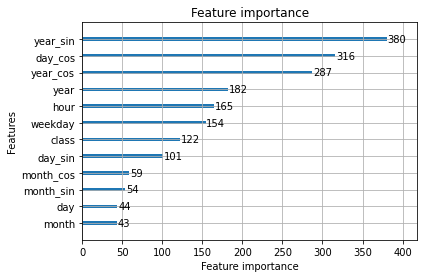

In [28]:
# plot importance
lgb.plot_importance(model)

In [ ]:
# for xgboost
import xgboost as xgb
from sklearn.metrics import mean_absolute_percentage_error

esr = 400 
nbr = 100

xgb_params = {
    "boosting_type":"gbdt", 
    "num_leaves":256,
    "max_depth":16,
    "learning_rate":0.3,
    "n_estimators":128,
    "subsample_for_bin":250000,
    "min_split_gain":0.7,
    "min_child_weight":1e-3,
    "min_child_samples":20,
    "subsample":0.7,
    "subsample_freq":0,
    "colsample_bytree":0.7,
    "reg_alpha":0.01,
    "reg_lambda":0.01,
    "n_jobs":-1,
    "metric":"mse",
    "num_threads" : 8,
    "enable_categorical":True,
    "use_label_encoder":False,
}

# custom metric for xgb
def custom_metric(y_pred, dataset):
    y_true = dataset.get_label()
    y_pred = y_pred
    eps = 1e-3
    score = np.mean((np.abs(y_true - y_pred)) / (y_true + eps))
    return 'custom_metric score', score

# training process with stacking ensemble
preds = []
preds_test = []
val_idxs = []
model_xgb_list = []

# categorical variable => int 형으로 변환
x_train["class"] = x_train["class"].astype("int")
x_train['holiday'] = x_train['holiday'].astype('int')
x_train["month"] = x_train["month"].astype("int")
x_train['day'] = x_train['day'].astype('int')
x_train["hour"] = x_train["hour"].astype("int")

x_test["class"] = x_test["class"].astype("int")
x_test['holiday'] = x_test['holiday'].astype('int')
x_test["month"] = x_test["month"].astype("int")
x_test['day'] = x_test['day'].astype('int')
x_test["hour"] = x_test["hour"].astype("int")

for idx, (tr_idx, val_idx) in enumerate(k_fold.split(x_train, x_train['class'])):

    tr_x, val_x = x_train.iloc[tr_idx], x_train.iloc[val_idx]
    tr_y, val_y = y_train.iloc[tr_idx], y_train.iloc[val_idx]

    train_data = xgb.DMatrix(tr_x, tr_y)
    valid_data = xgb.DMatrix(val_x, val_y)
    test_data = xgb.DMatrix(x_test, y_test)

    model = xgb.XGBRegressor(**xgb_params)
    model.fit(tr_x, tr_y, early_stopping_rounds = esr, eval_set = [(val_x, val_y)])
    model_xgb_list.append(model)

    pred = model.predict(val_x)
    val_idxs.append(val_idx)
    pred = np.array([convert2origin(x) for x in pred])

    preds.append(pred)

    pred_test = model.predict(x_test)
    pred_test = np.array([convert2origin(x) for x in pred_test])
    preds_test.append(pred_test)

preds = np.concatenate(preds, axis = 0)
val_idxs = np.concatenate(val_idxs)
order = np.argsort(val_idxs)
preds_train_xgb = preds[order]
preds_test_xgb = np.mean(preds_test, axis = 0)

train_score = calc_nmae(y_train_origin.values.reshape(-1,1), preds_train_xgb.reshape(-1,1))
test_score = calc_nmae(y_test_origin.values.reshape(-1,1), preds_test_xgb.reshape(-1,1))

print("# xgb stacking ensemble train_score : {:.3f}".format(train_score))
print("# xgb stacking ensemble test_score : {:.3f}".format(test_score))

In [ ]:
# catboost parameter tunning
import numpy as np
import optuna

import catboost as cb
from sklearn.datasets import load_breast_cancer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# categorical variable => int 형으로 변환
x_train["class"] = x_train["class"].astype("category")
x_train['year'] = x_train['year'].astype('int')
x_train["month"] = x_train["month"].astype("int")
x_train['day'] = x_train['day'].astype('int')
x_train["hour"] = x_train["hour"].astype("int")

x_test["class"] = x_test["class"].astype("category")
x_test['year'] = x_test['year'].astype('int')
x_test["month"] = x_test["month"].astype("int")
x_test['day'] = x_test['day'].astype('int')
x_test["hour"] = x_test["hour"].astype("int")

cb_params = {
    "iterations" : 256,
    "learning_rate" : 0.5,
    "task_type" : "GPU",
    "loss_function" : "MAPE", 
}

def objective(trial):
    
    param = {
        "loss_function" : trial.suggest_categorical("loss_function",["MAPE"]),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 1, 12),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
        "used_ram_limit": "3gb",
    }

    cb_features = x_train.columns[x_train.dtypes == 'category'].to_list()

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    gbm = CatBoostRegressor(**param)
    gbm.fit(x_train, y_train, eval_set=(x_test, y_test), cat_features = cb_features, verbose=0, early_stopping_rounds=256)
    preds = gbm.predict(x_test)
    preds = np.array([convert2origin(x) for x in preds])
    accuracy = calc_nmae(y_test_origin.values.reshape(-1,1), preds.reshape(-1,1))

    return accuracy

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, timeout=600)
print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")

for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

In [ ]:
# for catboost
cb_params = {
    "iterations" : 256,
    "learning_rate" : 0.3,
    "task_type" : "GPU",
    "loss_function" : "MAPE", 
}

# x_train["weekday"] = x_train["weekday"].astype("category")
# x_train["class"] = x_train["class"].astype("category")
# x_train['month'] = x_train["month"].astype("category")
# x_train['day'] = x_train["day"].astype("category")
# x_train['hour'] = x_train["hour"].astype("category")

# x_test["weekday"] = x_test["weekday"].astype("category")
# x_test["class"] = x_test["class"].astype("category")
# x_test['month'] = x_test["month"].astype("category")
# x_test['day'] = x_test["day"].astype("category")
# x_test['hour'] = x_test["hour"].astype("category")

cb_features = x_train.columns[x_train.dtypes == 'category'].to_list()

preds = []
preds_test = []
val_idxs = []
model_cbr_list = []

for idx, (tr_idx, val_idx) in enumerate(k_fold.split(x_train, x_train['class'])):

    tr_x, val_x = x_train.iloc[tr_idx], x_train.iloc[val_idx]
    tr_y, val_y = y_train.iloc[tr_idx], y_train.iloc[val_idx]

    model = CatBoostRegressor(**cb_params)
    model.fit(tr_x, tr_y, eval_set = (val_x, val_y), cat_features=cb_features)
    model_cbr_list.append(model)

    pred = model.predict(val_x)
    val_idxs.append(val_idx)
    pred = np.array([convert2origin(x) for x in pred])
    preds.append(pred)

    pred_test = model.predict(x_test)
    pred_test = np.array([convert2origin(x) for x in pred_test])
    preds_test.append(pred_test)

preds = np.concatenate(preds, axis = 0)
val_idxs = np.concatenate(val_idxs)
order = np.argsort(val_idxs)
preds_train_cbc = preds[order]
preds_test_cbc = np.mean(preds_test, axis = 0)
#preds_test_cbc = np.array([convert2origin(x) for x in preds_test_cbc])

train_score = calc_nmae(y_train_origin.values.reshape(-1,1), preds_train_cbc.reshape(-1,1))
test_score = calc_nmae(y_test_origin.values.reshape(-1,1), preds_test_cbc.reshape(-1,1))

print("# Catboost stacking ensemble train_score : {:.3f}".format(train_score))
print("# Catboost stacking ensemble test_score : {:.3f}".format(test_score))

0:	learn: 0.1191470	test: 0.1193122	best: 0.1193122 (0)	total: 24.4ms	remaining: 6.22s
1:	learn: 0.0900374	test: 0.0901684	best: 0.0901684 (1)	total: 47ms	remaining: 5.97s
2:	learn: 0.0697150	test: 0.0697825	best: 0.0697825 (2)	total: 66.2ms	remaining: 5.58s
3:	learn: 0.0544496	test: 0.0544343	best: 0.0544343 (3)	total: 90ms	remaining: 5.67s
4:	learn: 0.0440534	test: 0.0440370	best: 0.0440370 (4)	total: 110ms	remaining: 5.53s
5:	learn: 0.0380384	test: 0.0380179	best: 0.0380179 (5)	total: 132ms	remaining: 5.49s
6:	learn: 0.0336245	test: 0.0335713	best: 0.0335713 (6)	total: 151ms	remaining: 5.37s
7:	learn: 0.0304933	test: 0.0304574	best: 0.0304574 (7)	total: 172ms	remaining: 5.34s
8:	learn: 0.0286339	test: 0.0286009	best: 0.0286009 (8)	total: 194ms	remaining: 5.32s
9:	learn: 0.0269439	test: 0.0269515	best: 0.0269515 (9)	total: 215ms	remaining: 5.28s
10:	learn: 0.0255973	test: 0.0255349	best: 0.0255349 (10)	total: 234ms	remaining: 5.2s
11:	learn: 0.0249146	test: 0.0248252	best: 0.0248252 

In [ ]:
# neural prophet
!pip install git+https://github.com/ourownstory/neural_prophet.git
output.clear()

In [ ]:
from neuralprophet import NeuralProphet, set_log_level
from neuralprophet.benchmark import Dataset, NeuralProphetModel, ProphetModel
from neuralprophet.benchmark import SimpleBenchmark, CrossValidationBenchmark

model_prophet_list = [NeuralProphet() for _ in range(len(class_list))]

pred_train_list = []
pred_test_list = []

prophet_col = 'power'

for cls, model in zip(class_list, model_prophet_list):
    df_class = df_train[df_train["class"] == class_to_idx(cls)]

    df_input = pd.DataFrame()
    df_input['ds'] = df_class['time']
    df_input['y'] = df_class[prophet_col]

    loss = model.fit(df_input, freq = 'H')
    pred_train = model.predict(df_input)['yhat1'].values

    if prophet_col == "log_power":
        pred_train = np.array([convert2origin(x) for x in pred_train])
    pred_train_list.append(pred_train)

    df_pred = pd.DataFrame()
    df_pred['ds'] = df_test[df_test["class"] == class_to_idx(cls)]['time'].reset_index(drop = True)
    df_pred['y'] = np.array([None for _ in range(len(df_pred))])
    pred_test = model.predict(df_pred)['yhat1'].values
    
    if prophet_col == "log_power":
        pred_test = np.array([convert2origin(x) for x in pred_test])
    pred_test_list.append(pred_test)

output.clear()

In [ ]:
# evaluation
for cls, pred_train, pred_test in zip(class_list, pred_train_list, pred_test_list):

    train_actual = df_train[df_train["class"] == class_to_idx(cls)]["power"].values.reshape(-1,1)
    test_actual = df_test[df_test["class"] == class_to_idx(cls)]["power"].values.reshape(-1,1)

    train_score = calc_nmae(train_actual, pred_train.reshape(-1,1))
    test_score = calc_nmae(test_actual, pred_test.reshape(-1,1))
    
    print("# Neural Prophet with class :{}, train score:{:.3f} ".format(cls,train_score))
    print("# Neural Prophet with class :{}, test score:{:.3f} ".format(cls, test_score))

# Neural Prophet train score:0.174 with class :A
# Neural Prophet test score:0.229 with class :A
# Neural Prophet train score:0.212 with class :B
# Neural Prophet test score:0.235 with class :B
# Neural Prophet train score:0.109 with class :C
# Neural Prophet test score:0.174 with class :C
# Neural Prophet train score:0.179 with class :D
# Neural Prophet test score:0.191 with class :D
# Neural Prophet train score:0.177 with class :E
# Neural Prophet test score:0.224 with class :E
# Neural Prophet train score:0.121 with class :G
# Neural Prophet test score:0.142 with class :G
# Neural Prophet train score:0.207 with class :H
# Neural Prophet test score:0.214 with class :H


In [ ]:
preds_train_prophet = None
preds_test_prophet = None
for pred_train, pred_test in zip(pred_train_list, pred_test_list):

    if preds_train_prophet is None:
        preds_train_prophet = pred_train
    else:
        preds_train_prophet = np.concatenate((preds_train_prophet, pred_train), axis = 0)

    if preds_test_prophet is None:
        preds_test_prophet = pred_test
    else:
        preds_test_prophet = np.concatenate((preds_test_prophet, pred_test), axis = 0)

In [ ]:
train_score = calc_nmae(y_train_origin.values.reshape(-1,1), preds_train_prophet.reshape(-1,1))
test_score = calc_nmae(y_test_origin.values.reshape(-1,1), preds_test_prophet.reshape(-1,1))

print("# Neural Prophet train score:{:.3f}".format(train_score))
print("# Neural Prophet test score:{:.3f}".format(test_score))

# Neural Prophet train score:0.169
# Neural Prophet test score:0.201


In [ ]:
# average
pred_train_average = (preds_train_lgb + preds_train_xgb + preds_train_cbc + preds_train_prophet)/4
pred_test_average = (preds_test_lgb + preds_test_xgb + preds_test_cbc + preds_test_prophet) / 4

train_score = calc_nmae(y_train_origin.values.reshape(-1,1), pred_train_average.reshape(-1,1))
test_score = calc_nmae(y_test_origin.values.reshape(-1,1), pred_test_average.reshape(-1,1))

print("# stacking ensemble train_score : {:.3f}".format(train_score))
print("# stacking ensemble test_score : {:.3f}".format(test_score))

# stacking ensemble train_score : 0.071
# stacking ensemble test_score : 0.143


In [ ]:
# average without prophet
# 성능이 떨어지더라도 average ensemble로 전체 loss가 감소할 수 있다. 
pred_train_average = (preds_train_lgb + preds_train_xgb + preds_train_cbc )/3
pred_test_average = (preds_test_lgb + preds_test_xgb + preds_test_cbc ) / 3

train_score = calc_nmae(y_train_origin.values.reshape(-1,1), pred_train_average.reshape(-1,1))
test_score = calc_nmae(y_test_origin.values.reshape(-1,1), pred_test_average.reshape(-1,1))

print("# stacking ensemble train_score : {:.3f}".format(train_score))
print("# stacking ensemble test_score : {:.3f}".format(test_score))

# stacking ensemble train_score : 0.055
# stacking ensemble test_score : 0.145


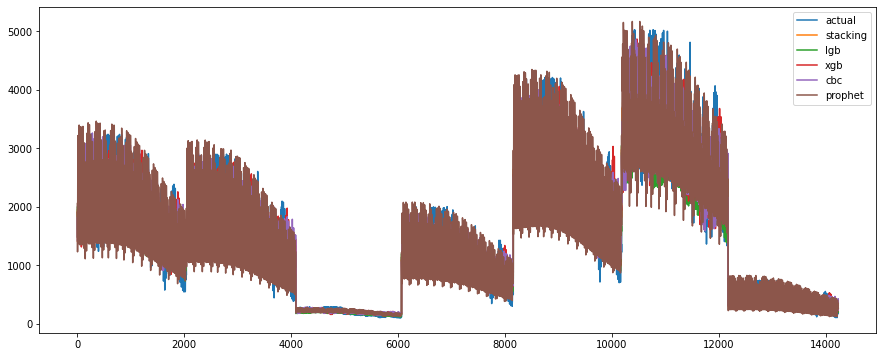

In [ ]:
plt.figure(figsize = (15, 6))
plt.plot(y_test_origin.values, label = "actual")
plt.plot(pred_test_average, label = "stacking")
plt.plot(preds_test_lgb, label = "lgb")
plt.plot(preds_test_xgb, label = "xgb")
plt.plot(preds_test_cbc, label = "cbc")
plt.plot(preds_test_prophet, label = "prophet")
plt.legend()
plt.show()

In [ ]:
# submission
idx_to_class = ['A','B','C','D',"E",'G','H']

df_submission = test_csv.copy()
df_submission = df_time_convert(df_submission)

df_submission['class'] = df_submission['class'].apply(lambda x : class_to_idx(x))
df_submission['class'] = df_submission['class'].astype("category")

df_submission["month_cos"] = np.cos(df_submission.time.map(datetime.datetime.timestamp) * (2 * np.pi / month))
df_submission["month_sin"] = np.sin(df_submission.time.map(datetime.datetime.timestamp) * (2 * np.pi / month))

df_submission["year_cos"] = np.cos(df_submission.time.map(datetime.datetime.timestamp) * (2 * np.pi / year))
df_submission["year_sin"] = np.sin(df_submission.time.map(datetime.datetime.timestamp) * (2 * np.pi / year))

df_submission["day_cos"] = np.cos(df_submission.hour.values * (2 * np.pi / 24))
df_submission["day_sin"] = np.sin(df_submission.hour.values * (2 * np.pi / 24))

# 공휴일 유무에 대한 categorical variable 추가
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

dr = df_submission['time']

cal = calendar()
holidays = cal.holidays(start=dr.min(), end=dr.max())
df_submission['holiday'] = df_submission['time'].isin(cal.holidays())

# categorical variable로 전환
df_submission["class"] = df_submission["class"].astype("category")
df_submission["class"] = df_submission["class"].apply(lambda x : int(x))

df_submission['holiday'] = df_submission['holiday'].astype('category')
df_submission['holiday'] = df_submission['holiday'].apply(lambda x : int(x))

output.clear()

In [ ]:
x_cols = ["year_cos", "year_sin", "month_cos", "month_sin", "day_cos", "day_sin", "class", "holiday"]

x_submission = df_submission[x_cols]

preds_submission_lgb = []
preds_submission_xgb = []
preds_submission_cbr = []
preds_submission_prophet = []

# lgbm prediction
for model in model_lgb_list:
    pred = model.predict(x_submission)
    pred = np.array([convert2origin(x) for x in pred])
    preds_submission_lgb.append(pred)

# catboost prediction
for model in model_cbr_list:
    pred = model.predict(x_submission)
    pred = np.array([convert2origin(x) for x in pred])
    preds_submission_cbr.append(pred)

# xgb : 형 변환
x_submission['class'] = x_submission['class'].astype('int')
x_submission['holiday'] = x_submission['holiday'].astype('int')

# xgboost prediction
for model in model_xgb_list:
    pred = model.predict(x_submission)
    pred = np.array([convert2origin(x) for x in pred])
    preds_submission_xgb.append(pred)

# prophet prediction
for cls, model in zip(class_list, model_prophet_list):
    df_class = df_submission[df_submission["class"] == class_to_idx(cls)]
    df_input = pd.DataFrame()
    df_input['ds'] = df_class['time']
    df_input['y'] = np.array([None for _ in range(len(df_input))])
    pred = model.predict(df_input)['yhat1'].values
    pred = np.array([convert2origin(x) for x in pred])
    preds_submission_prophet.append(pred)


preds_submission_lgb = np.mean(preds_submission_lgb, axis = 0)
preds_submission_xgb = np.mean(preds_submission_xgb, axis = 0)
preds_submission_cbr = np.mean(preds_submission_cbr, axis = 0)
preds_submission_prophet = np.concatenate(preds_submission_prophet, axis = 0)

predictions = (preds_submission_cbr + preds_submission_lgb + preds_submission_xgb + preds_submission_prophet) / 4

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
sample_submission["공급량"] = predictions

# submission 
from google.colab import files
sample_submission.to_csv("submission_1206.csv", index = False)
files.download("submission_1206.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>